# Assignment 2/B
**Disclaimer: Only for ADL/AML students!**

### General information
**You have to solve all tasks to pass!** 

Grade is calculated by the day of the last submission, but you will only get it after you've succesfully presented it. 

*Deadlines and grades:* 
  * 2020.10.27 - 2020.11.24 ==> 5
  * 2020.11.25 - 2020.12.01 ==> 4
  * 2020.12.02 - 2020.12.08 ==> 3
  * 2020.12.09 - 2020.12.15 ==> 2
  * 2020.12.16 or later ==> 1

### Description
In this assignment you have to build a Mask R-CNN based keypoint detector model using [Detectron2](https://github.com/facebookresearch/detectron2). Detectron2 was written in PyTorch and contains many state-of-the-art obejct detection models with pretrained weights. (*Don't worry, you don't have to use any PyTorch specific function, just the methods provided by the Detectron2 package.*) 

First, you have to preprocess and then convert the Cats Dataset to COCO format. After that, finetune a pretrained keypoint model (which was trained on COCO dataset) to predict cat keypoints. Finally, to see the results, run it on some videos.

**You can use this notebook for guidance: https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5**

*__Optional:__ You can get better a better grade on one of your assignments, if you temporally extend this method. By matching the bounding boxes using Hungarian algorithm, you can create a simple tracking method without modifying the network. Here you can find a good explanation of how it works: https://towardsdatascience.com/computer-vision-for-tracking-8220759eee85 (It's enough to only implement the Hungarian matching part without using Kalman filter.)*  

### Use GPU
Runtime -> Change runtime type

At Hardware accelerator select  GPU then save it.  

### Useful shortcuts
* Run selected cell: *Ctrl + Enter*
* Insert cell below: *Ctrl + M B*
* Insert cell above: *Ctrl + M A*
* Convert to text: *Ctrl + M M*
* Split at cursor: *Ctrl + M -*
* Autocomplete: *Ctrl + Space* or *Tab*
* Move selected cells up: *Ctrl + M J*
* Move selected cells down: *Ctrl + M K*
* Delete selected cells: *Ctrl + M D*


### Tips
* **You may need to restart the notebook if the following cell returns some errors (red texts).**
* To prevent Google colab from disconnecting: https://medium.com/@shivamrawat_756/how-to-prevent-google-colab-from-disconnecting-717b88a128c0 

If you have any question, feel free to ask. 
kopacsi@inf.elte.hu

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1 'pycocotools>=2.0.1'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode


# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


## Prepare dataset

* Download the Cats dataset. We will only use a subset of the original dataset, the CAT_00 folder. Here you can find more information about the dataset: https://www.kaggle.com/crawford/cat-dataset
* Preprocess the data. You can find some help here: https://github.com/kairess/cat_hipsterizer/blob/master/preprocess.py
  * Following the steps in the link above, read the images (don't resize them).
  * Keep only the left eye, right eye and mouth coordinates.
  * Generate bounding boxes by taking the min and max keypoint coordinates. *Note: Add +10 pixels to the max bounding box coordinates to include the entire head of the cat.*
* Split the dataset into train-test sets (ratio: 80-20), without shuffling, and print the size of each set.
* Convert the datasets to COCO format. Here you can find the format: https://detectron2.readthedocs.io/tutorials/datasets.html#standard-dataset-dicts 
  * You only need to use these fields: `file_name, height, width, image_id, annotations`.
  * Each `annotation` field should contain a list that contains a dictionary with the following keys: `bbox, bbox_mode, category_id, iscrowd, keypoints` (***Note #1**: the value of the `category_id` and the `iscrowd` should be 0. **Note #2**: After each keypoint you need to add a visibility flag too. The value of the visibility flag should be 2, as according to the documentation: all keypoints are labeled and visible.*)
* Finally, register the datasets and visualize some (e.g. 3) samples (randomly), to check that everything works fine.
  * You have to set the `MetadataCatalog` as well, see: https://detectron2.readthedocs.io/tutorials/datasets.html#metadata-for-datasets 
    * These `fields` should be specified: `thing_classes, keypoint_names, keypoint_flip_map, keypoint_connection_rules`.

In [ ]:
# Download from Drive
!if ! [ -f CAT_00.zip ]; then curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=1wGwNi8t-UKAKs-LQL3dG-D8dzGVPHv2w" > /dev/null; curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1wGwNi8t-UKAKs-LQL3dG-D8dzGVPHv2w" -o CAT_00.zip; fi

# Check if the file size is correct (~402MB)
!if (( $(stat -c%s CAT_00.zip) < 421896648 )); then rm -rfd CAT_00.zip; fi

# If not, download it from NIPG12
!wget -nc -O CAT_00.zip http://nipg1.inf.elte.hu:8000/CAT_00.zip

File ‘CAT_00.zip’ already there; not retrieving.


In [ ]:
!unzip -o CAT_00.zip

Archive:  CAT_00.zip
 extracting: CAT_00/00000001_000.jpg  
  inflating: CAT_00/00000001_000.jpg.cat  
 extracting: CAT_00/00000001_005.jpg  
  inflating: CAT_00/00000001_005.jpg.cat  
 extracting: CAT_00/00000001_008.jpg  
  inflating: CAT_00/00000001_008.jpg.cat  
 extracting: CAT_00/00000001_011.jpg  
  inflating: CAT_00/00000001_011.jpg.cat  
 extracting: CAT_00/00000001_012.jpg  
  inflating: CAT_00/00000001_012.jpg.cat  
 extracting: CAT_00/00000001_016.jpg  
  inflating: CAT_00/00000001_016.jpg.cat  
 extracting: CAT_00/00000001_017.jpg  
  inflating: CAT_00/00000001_017.jpg.cat  
 extracting: CAT_00/00000001_020.jpg  
  inflating: CAT_00/00000001_020.jpg.cat  
  inflating: CAT_00/00000001_024.jpg  
  inflating: CAT_00/00000001_024.jpg.cat  
  inflating: CAT_00/00000001_027.jpg  
  inflating: CAT_00/00000001_027.jpg.cat  
 extracting: CAT_00/00000001_029.jpg  
  inflating: CAT_00/00000001_029.jpg.cat  
 extracting: CAT_00/00000002_001.jpg  
  inflating: CAT_00/00000002_001.jpg.c

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
import sklearn
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import os
from pandas import DataFrame

In [ ]:
import shutil

base_path = '/content/CAT_00'
file_list = sorted(os.listdir(base_path))

file_list = [f for f in file_list if '.cat' in f]

train_files = file_list[:(int(len(file_list)*0.8))]
test_files = [i for i in file_list if i not in train_files]
print("all image nums: ", len(file_list))
print("train image nums: ", len(train_files))
print("test image nums: ", len(test_files))

train_label_path = '/content/CAT_00/train'
test_label_path = '/content/CAT_00/test'

if not os.path.exists(train_label_path):
  os.mkdir(train_label_path)

if not os.path.exists(test_label_path):
  os.mkdir(test_label_path)

for i in train_files:
  shutil.move(os.path.join(base_path, i), train_label_path)

for i in test_files:
  shutil.move(os.path.join(base_path, i), test_label_path)

all image nums:  1706
train image nums:  1364
test image nums:  342


Error: ignored

In [ ]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def transform_to_coco(data_dir):
  dataset_dicts = []
  for idx, filename in enumerate(os.listdir(data_dir)):
    record = {}
    pd_frame = pd.read_csv(os.path.join(data_dir, filename), sep=' ', header=None)
    # landmarks = (pd_frame.values[0][1:-1]).reshape((-1,2))
    landmarks = (pd_frame.iloc[0][1:7]).to_numpy().reshape((-1, 2))
    # print(landmarks)
    
    file_name, ext = os.path.splitext(filename)
    img_path = os.path.join('/content/CAT_00', file_name)
    height, width = cv2.imread(img_path).shape[:2]
    record["file_name"] = img_path
    record["image_id"] = idx
    record["height"] = height
    record["width"] = width
    bb = np.array([np.min(landmarks, axis=0)-10, np.max(landmarks, axis=0)+10])
    objs = []
    landmarks_info = []
    obj = {
        "bbox":[bb[0][0].astype(int),
           bb[0][1].astype(int),
           bb[1][0].astype(int),
           bb[1][1].astype(int)],
        "num_keypoints":3,
        "bbox_mode": BoxMode.XYXY_ABS,
        "keypoints": [
                landmarks[0][0].astype(int),landmarks[0][1].astype(int),2,
                landmarks[1][0].astype(int),landmarks[1][1].astype(int),2,
                landmarks[2][0].astype(int),landmarks[2][1].astype(int),2
              ],
          
        "category_id": 0,
        "iscrowd": 0,
        }
    objs.append(obj)    
    record["annotations"] = objs
    dataset_dicts.append(record)
  return dataset_dicts

In [ ]:
for d in ["train", "test"]:
  DatasetCatalog.register("cats_" + d, lambda d=d: transform_to_coco("/content/CAT_00/" + d))
  MetadataCatalog.get("cats_" + d).set(thing_classes=["cat"])
  MetadataCatalog.get("cats_" + d).set(keypoint_names=["1","2","3"])
  MetadataCatalog.get("cats_" + d).set(keypoint_flip_map=[])
  MetadataCatalog.get("cats_" + d).set(keypoint_connection_rules=[])

cat_metadata = MetadataCatalog.get("cat_train")

In [ ]:
dataset_dicts = transform_to_coco("/content/CAT_00/train")


{'file_name': '/content/CAT_00/00000092_019.jpg', 'image_id': 823, 'height': 361, 'width': 500, 'annotations': [{'bbox': [245, 135, 336, 219], 'num_keypoints': 3, 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'keypoints': [255, 145, 2, 326, 145, 2, 283, 209, 2], 'category_id': 0, 'iscrowd': 0}]}


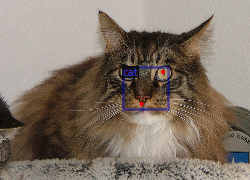

{'file_name': '/content/CAT_00/00000084_012.jpg', 'image_id': 906, 'height': 609, 'width': 1024, 'annotations': [{'bbox': [637, 262, 748, 352], 'num_keypoints': 3, 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'keypoints': [647, 285, 2, 738, 272, 2, 701, 342, 2], 'category_id': 0, 'iscrowd': 0}]}


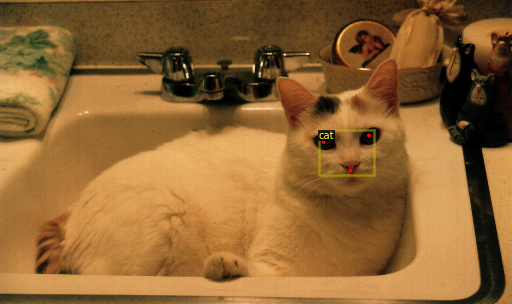

{'file_name': '/content/CAT_00/00000059_000.jpg', 'image_id': 494, 'height': 375, 'width': 500, 'annotations': [{'bbox': [244, 87, 300, 140], 'num_keypoints': 3, 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'keypoints': [254, 98, 2, 290, 97, 2, 277, 130, 2], 'category_id': 0, 'iscrowd': 0}]}


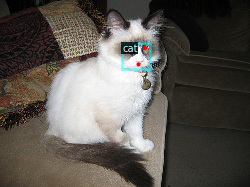

In [ ]:

for d in random.sample(dataset_dicts, 3):
    print(d)
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=cat_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("cats_train",)
cfg.DATASETS.TEST = ()


cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 9
cfg.TEST.KEYPOINT_OKS_SIGMAS = [.079, .107, .089]

cfg.MODEL.ROI_KEYPOINT_HEAD.MIN_KEYPOINTS_PER_IMAGE = 1

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[01/05 20:09:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.keypoint_head.score_lowres.weight' to the model due to incompatible shapes: (512, 17, 4, 4) in the checkpoint but (512, 9, 4, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.keypoint_head.score_lowres.bias' to the model due to incompatible shapes: (17,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.


[01/05 20:10:06 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:217: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


[01/05 20:10:26 d2.utils.events]:  eta: 0:16:28  iter: 19  total_loss: 8.321  loss_cls: 0.05991  loss_box_reg: 0.01945  loss_keypoint: 8.07  loss_rpn_cls: 0.1425  loss_rpn_loc: 0.01225  time: 1.0158  data_time: 0.0547  lr: 4.9952e-05  max_mem: 5392M
[01/05 20:10:46 d2.utils.events]:  eta: 0:16:34  iter: 39  total_loss: 8.329  loss_cls: 0.1038  loss_box_reg: 0.04133  loss_keypoint: 8.064  loss_rpn_cls: 0.095  loss_rpn_loc: 0.01051  time: 1.0241  data_time: 0.0387  lr: 9.9902e-05  max_mem: 5392M
[01/05 20:11:08 d2.utils.events]:  eta: 0:16:32  iter: 59  total_loss: 8.301  loss_cls: 0.1243  loss_box_reg: 0.06664  loss_keypoint: 8.049  loss_rpn_cls: 0.0595  loss_rpn_loc: 0.009482  time: 1.0507  data_time: 0.0346  lr: 0.00014985  max_mem: 5392M
[01/05 20:11:32 d2.utils.events]:  eta: 0:16:23  iter: 79  total_loss: 8.244  loss_cls: 0.08416  loss_box_reg: 0.06866  loss_keypoint: 8.032  loss_rpn_cls: 0.02098  loss_rpn_loc: 0.01426  time: 1.0787  data_time: 0.0488  lr: 0.0001998  max_mem: 5392M

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("cats_test", ("bbox", "keypoints"), False, output_dir="./output/", kpt_oks_sigmas=(.079, .107, .089))
val_loader = build_detection_test_loader(cfg, "cats_test")
aa = inference_on_dataset(trainer.model, val_loader, evaluator)
print(aa)

[01/05 20:40:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/05 20:40:30 d2.data.common]: Serializing 342 elements to byte tensors and concatenating them all ...
[01/05 20:40:30 d2.data.common]: Serialized dataset takes 0.17 MiB
[01/05 20:40:30 d2.evaluation.evaluator]: Start inference on 342 images
[01/05 20:40:32 d2.evaluation.evaluator]: Inference done 11/342. 0.1124 s / img. ETA=0:00:37
[01/05 20:40:37 d2.evaluation.evaluator]: Inference done 55/342. 0.1143 s / img. ETA=0:00:33
[01/05 20:40:42 d2.evaluation.evaluator]: Inference done 98/342. 0.1156 s / img. ETA=0:00:28
[01/05 20:40:47 d2.evaluation.evaluator]: Inference done 138/342. 0.1179 s / img. ETA=0:00:24
[01/05 20:40:52 d2.evaluation.evaluator]: Inference done 181/342. 0.1175 s / img. ETA=0:00:19
[01/05 20:40:57 d2.evaluation.evaluator]: Inference done 222/342. 0.1183 s / img. ETA=0:00:14
[01/05 20:41:02 

AssertionError: ignored

Skip loading parameter 'roi_heads.keypoint_head.score_lowres.weight' to the model due to incompatible shapes: (512, 9, 4, 4) in the checkpoint but (512, 3, 4, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.keypoint_head.score_lowres.bias' to the model due to incompatible shapes: (9,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.


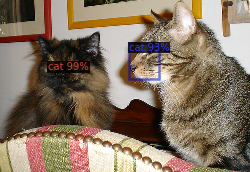

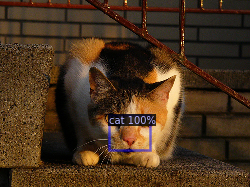

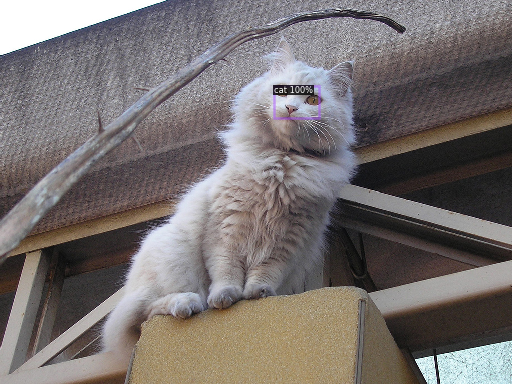

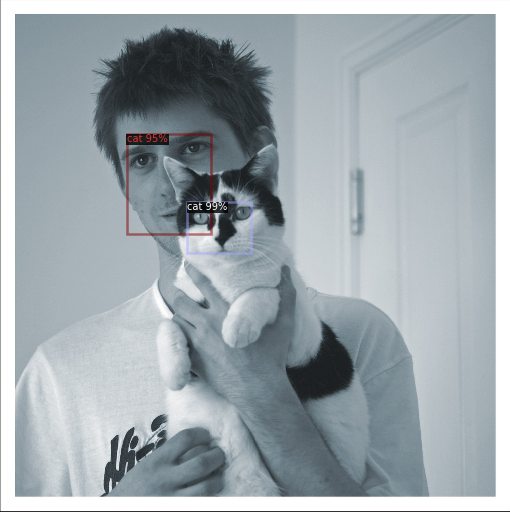

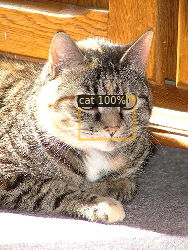

In [ ]:

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   
predictor = DefaultPredictor(cfg)

from detectron2.utils.visualizer import ColorMode
dataset_dicts = transform_to_coco("/content/CAT_00/test")
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=cat_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

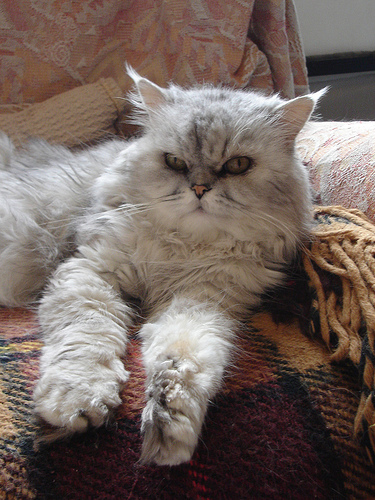

In [ ]:

#create result floder
path = '/content/CAT_00/'
CatFile = os.listdir(path)
CatImage_path = '/content/CatImages/'
Train_path = 'content/CatImages/Train'
Test_path = 'content/CatImages/Test'
columns_name1 = ['number','left_eye_x','left_eye_y','right_eye_x','right_eye_y','mouth_x','mouth_y',
          'left_ear_1_x','left_ear_1_y', 'right_ear_1_x','right_ear_1_y',
          'left_ear_2_x','left_ear_2_y','right_ear_2_x','right_ear_2_y',
          'left_ear_3_x','left_ear_3_y','right_ear_3_x','right_ear_3_y'
          ]
columns_name2 = ['pic_name','left_eye_x','left_eye_y','right_eye_x','right_eye_y','mouth_x','mouth_y']
df = pd.DataFrame(columns=columns_name2)
#create two files to save the cat image and heatmap image
if not os.path.exists(CatImage_path):
  os.makedirs(CatImage_path)

for file in CatFile:
  if file.endswith('.cat'):
    # save the all label into all_df
    all_df = pd.read_csv(path+file,sep=' ',names =columns_name1,index_col=False)
    #图片原始的位置
    imgpath = path+file[0:16]
    image = cv2.imread(imgpath)
    # print(imgpath)
    # cv2_imshow(image)
    #to create the first column as the image file name,so cut down the '.cat'
    all_df['pic_name']=CatImage_path + file[0:16]
    # pic_name = row['pic_name']
    #想要存入图片的位置
   
    cv2.imwrite(os.path.join(CatImage_path , file[0:16]), image)
    df = df.append(all_df[columns_name2])
cat_list = [f for f in cat_list]
im = cv2.imread('/content/CAT_00/00000001_000.jpg')
cv2_imshow(im)

In [ ]:
df.head()

pic_name left_eye_x  ... mouth_x mouth_y
0  /content/CatImages/00000392_028.jpg        228  ...     290     227
0  /content/CatImages/00000310_029.jpg        322  ...     413     860
0  /content/CatImages/00000026_001.jpg        263  ...     275     106
0  /content/CatImages/00000001_008.jpg        318  ...     327     238
0  /content/CatImages/00000432_019.jpg        101  ...     140     211

[5 rows x 7 columns]

In [ ]:
df.to_csv('cat_key_point.csv',index=True)

In [ ]:
# now read the image, reshape the image to the keypoint
 # first ,copy the df to a new df

new_df = pd.DataFrame(columns=columns_name2)
image_df = df.copy()

# for index, row in image_df.iterrows():
#   pic_name = row['pic_name']
#   filepath = path+pic_name
#   image = cv2.imread(pic_name,1)
 
#   plt.imshow(image)
#   plt.show()
#   #这个必须在image resize 以后再定义
#   left_eye_x = row['left_eye_x']
#   left_eye_y = row['left_eye_y']
#   right_eye_x = row['right_eye_x']
#   right_eye_y = row['right_eye_y']
#   mouth_x = row['mouth_x']
#   mouth_y = row['mouth_y']
#   cv2_imshow(image)
#   cv2.imwrite(pic_name, image)
#   new_df = new_df.append(row)

# new_df


In [ ]:
image_df.shape

(1706, 7)

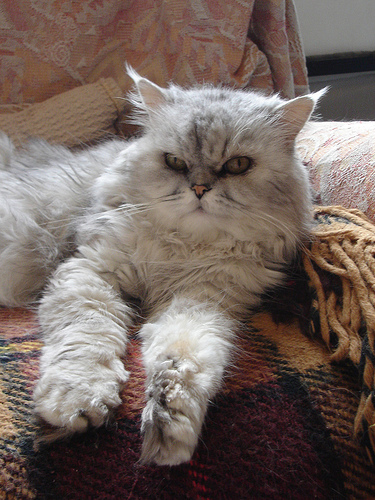

In [ ]:
im = cv2.imread('/content/CAT_00/00000001_000.jpg')
cv2_imshow(im)

In [ ]:
from detectron2.structures import BoxMode

In [ ]:
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
img_size = 224
dirname = 'CAT_00'
base_path = '/content/%s' % dirname
img_path = '/content/CatImages/'
file_list = sorted(os.listdir(base_path))
# print(file_list)
# random.shuffle(file_list)

dataset = {
    'file_name':[],
    'imgs': [],
    'lmks': [],
    'bbs': []
}


for f in file_list:
  if '.cat' not in f:
    continue
  # print(f[0:16])
  # read landmarks
  pd_frame = pd.read_csv(os.path.join(base_path, f), sep=' ', header=None)
  # aa = (pd_frame.iloc[0][1:7]).to_numpy()
  # print(aa)
  landmarks = (pd_frame.iloc[0][1:7]).to_numpy().reshape((-1, 2))
  # print(landmarks)
  # load image
  img_filename, ext = os.path.splitext(f)

  img = cv2.imread(os.path.join(base_path, img_filename))
  width,height,_ = img.shape
  # resize image and relocate landmarks
  bb = np.array([np.min(landmarks, axis=0)-10, np.max(landmarks, axis=0)+10])
  # print(bb[0])
  # print(bb[0][0])
  # print(bb[0][0].astype(int))
  dataset['file_name'].append(img_path + f[0:16])
  dataset['imgs'].append(img)
  dataset['lmks'].append(landmarks)
  dataset['bbs'].append(bb.flatten())
  # print("l for landmark:")
  for l in landmarks:
    # print(+l)
    cv2.circle(img, center=tuple(l.astype(int)), radius=5, color=(255, 0, 255), thickness=5)
  #这里，由于这个bb[0][0]里面的数据是一个float数据，但是坐标值必须是一个int值，所以需要将这个值用.astype(int)转化出来
  cv2.rectangle(img, (bb[0][0].astype(int), bb[0][1].astype(int)), (bb[1][0].astype(int), bb[1][1].astype(int)), (255,0,0), 2)  
  # print("b for bb:")
  # for b in bb:
  #   print(b)
  # cv2.imshow('img', img)
  # plt.imshow(img)
  # plt.show()
# for i in range(5):
#   plt.figure()
#   batch1 = img_generator.next()
#   plt.imshow(dataset['imgs'].astype('uint8'))
#   plt.show()
  # if cv2.waitKey(0) == ord('q'):
  #   break

In [ ]:
new_df = pd.DataFrame(columns=columns_name2)
image_df = df.copy()

In [ ]:
# dataset

In [ ]:
dataset2 = pd.DataFrame(data = dataset)


In [ ]:
dataset2.head(5)

file_name  ...                           bbs
0  /content/CatImages/00000001_000.jpg  ...  [165.0, 150.0, 249.0, 209.0]
1  /content/CatImages/00000001_005.jpg  ...    [86.0, 86.0, 163.0, 156.0]
2  /content/CatImages/00000001_008.jpg  ...  [308.0, 212.0, 350.0, 248.0]
3  /content/CatImages/00000001_011.jpg  ...  [157.0, 163.0, 252.0, 257.0]
4  /content/CatImages/00000001_012.jpg  ...  [105.0, 111.0, 189.0, 179.0]

[5 rows x 4 columns]

In [ ]:
dataset2['image_id'] = range(1,len(df)+1)
dataset2.head()

file_name  ... image_id
0  /content/CatImages/00000001_000.jpg  ...        1
1  /content/CatImages/00000001_005.jpg  ...        2
2  /content/CatImages/00000001_008.jpg  ...        3
3  /content/CatImages/00000001_011.jpg  ...        4
4  /content/CatImages/00000001_012.jpg  ...        5

[5 rows x 5 columns]

In [ ]:
dataset2['lmks'][0][1][1]

162.0

In [ ]:
# make the spilit dataset train, valiation, test
import sklearn.model_selection as model_selection
trainSet, testSet = model_selection.train_test_split(dataset2, test_size = 0.2, random_state =48)

In [ ]:
print(trainSet.shape,testSet.shape)

(1364, 5) (342, 5)


In [ ]:
trainSet.head()

file_name  ... image_id
1150  /content/CatImages/00000371_007.jpg  ...     1151
1499  /content/CatImages/00000427_001.jpg  ...     1500
336   /content/CatImages/00000046_021.jpg  ...      337
564   /content/CatImages/00000080_005.jpg  ...      565
686   /content/CatImages/00000300_026.jpg  ...      687

[5 rows x 5 columns]

## Try out the model
To test the model download the following image. Load the [pretrained R50-FPN 3x keypoint model](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-person-keypoint-detection-baselines-with-keypoint-r-cnn), evaluate it on the image, then visualize (plot) the result. 


In [ ]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def transform_to_coco(input):
  dataset_dicts = []
  
  for i in range(len(input)):
    record = {}
    # print(i)
    file_name = input['file_name'][i]
    image_id = input['image_id'][i]
    width,height,_ = input['imgs'][i].shape
    annotations = []
    obj ={
      "id":i+len(input),
      "num_keypoints":3,
      "keypoint":[input['lmks'][i][0][0].astype(int),
             input['lmks'][i][0][0].astype(int),
             2,
             input['lmks'][i][1][0].astype(int),
             input['lmks'][i][1][1].astype(int),
             2,
             input['lmks'][i][2][0].astype(int),
             input['lmks'][i][2][1].astype(int),
             2
             ],
      "bbox":[input['bbs'][i][0].astype(int),
          input['bbs'][i][1].astype(int),
          input['bbs'][i][2].astype(int),
          input['bbs'][i][3].astype(int)],
      # "image_id":input['image_id'][i],
      "bbox_mode": BoxMode.XYXY_ABS,
      "iscrowd":0,
      "category_id":0
      }
    annotations.append(obj)
    record["file_name"] = file_name
    record["image_id"] = image_id
    record["height"] = height
    record["width"] = width
    record["annotations"] =annotations
    dataset_dicts.append(record)
  return dataset_dicts


annotation是一个list，这里list的格式是[],这里里面的子内容就是json格式的内容
由于我的数据集里面只有一个annotation的值，不可能出现多个，所以，这里需要用到
先定义一个annotation的list  annotation=[]
然后定义一个obj,每次循环结束的时候，把这个objappend给这个annotation，由于
我这里只有一个obj，所以，就直接append一次后就可以将值赋值给records['annotaion
]

In [ ]:
dataset2_dicts = transform_to_coco(dataset2)

In [ ]:
dataset2_dicts

[{'annotations': [{'bbox': [165, 150, 249, 209],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0,
    'id': 1706,
    'iscrowd': 0,
    'keypoint': [175, 175, 2, 239, 162, 2, 199, 199, 2],
    'num_keypoints': 3}],
  'file_name': '/content/CatImages/00000001_000.jpg',
  'height': 375,
  'image_id': 1,
  'width': 500},
 {'annotations': [{'bbox': [86, 86, 163, 156],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0,
    'id': 1707,
    'iscrowd': 0,
    'keypoint': [96, 96, 2, 153, 127, 2, 103, 146, 2],
    'num_keypoints': 3}],
  'file_name': '/content/CatImages/00000001_005.jpg',
  'height': 500,
  'image_id': 2,
  'width': 375},
 {'annotations': [{'bbox': [308, 212, 350, 248],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0,
    'id': 1708,
    'iscrowd': 0,
    'keypoint': [318, 318, 2, 340, 224, 2, 327, 238, 2],
    'num_keypoints': 3}],
  'file_name': '/content/CatImages/00000001_008.jpg',
  'height': 500,
  'image_id': 3,
  'width': 375},
 {'an

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog

#注册数据集（这一步就是将自定义数据集注册进Detectron2）
DatasetCatalog.register("reg_dataset2", transform_to_coco(dataset2))
# MetadataCatalog.get("reg_dataset2").thing_classes = ["cat"]
# MetadataCatalog.get("reg_dataset2").keypoint_names=["1","2","3"]
# MetadataCatalog.get("reg_dataset2").keypoint_flip_map=[]
# MetadataCatalog.get("reg_dataset2").keypoint_connection_rules=[]
# cat_metadata = MetadataCatalog.get("reg_dataset2")
# cat_metadata

AssertionError: ignored

In [ ]:
#注册数据集（将trainset和testset进行注册
for d in [trainSet, testSet]:
    DatasetCatalog.register("reg_" + d, lambda d=d: transform_to_coco(d))
    MetadataCatalog.get("reg_" + d).set(thing_classes=["cat"])

# DatasetCatalog.register("reg_trainSet", transform_to_coco("trainSet"))
# MetadataCatalog.get("reg_trainSet").set(thing_classes = ["cat"])
# MetadataCatalog.get("reg_trainSet").set(keypoint_names=["1","2","3"])
# MetadataCatalog.get("reg_trainSet").set(keypoint_flip_map=[])
# MetadataCatalog.get("reg_trainSet").set(keypoint_connection_rules=[])

# DatasetCatalog.register("reg_testSet", transform_to_coco("testSet"))
# MetadataCatalog.get("reg_testSet").thing_classes = ["cat"]
# MetadataCatalog.get("reg_testSet").keypoint_names=["1","2","3"]
# MetadataCatalog.get("reg_testSet").keypoint_flip_map=[]
# MetadataCatalog.get("reg_testSet").keypoint_connection_rules=[]

UFuncTypeError: ignored

{'file_name': '/content/CatImages/00000395_013.jpg', 'image_id': 1314, 'height': 434, 'width': 500, 'annotations': [{'id': 3019, 'num_keypoints': 3, 'keypoint': [158, 158, 2, 192, 144, 2, 169, 175, 2], 'bbox': [148, 134, 202, 185], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'iscrowd': 0, 'category_id': 0}]}


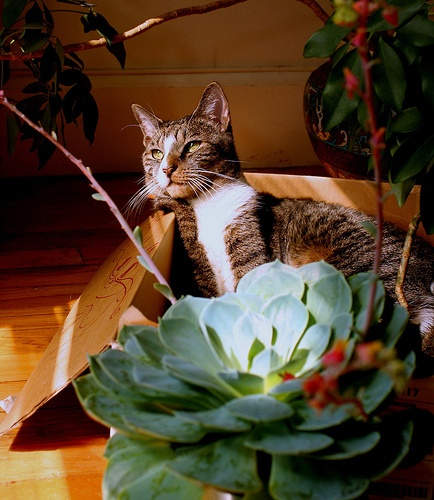

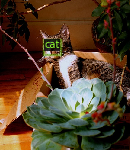

{'file_name': '/content/CatImages/00000418_006.jpg', 'image_id': 1451, 'height': 500, 'width': 375, 'annotations': [{'id': 3156, 'num_keypoints': 3, 'keypoint': [386, 386, 2, 424, 214, 2, 395, 228, 2], 'bbox': [376, 172, 434, 238], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'iscrowd': 0, 'category_id': 0}]}


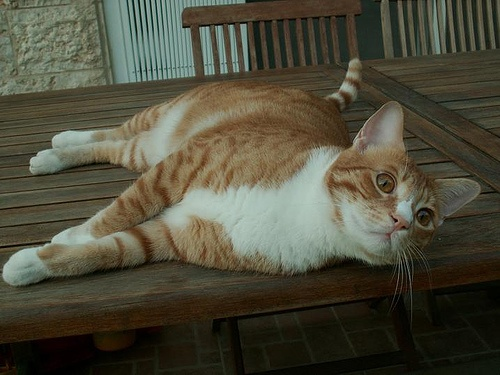

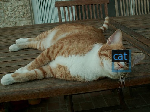

{'file_name': '/content/CatImages/00000045_028.jpg', 'image_id': 331, 'height': 341, 'width': 500, 'annotations': [{'id': 2036, 'num_keypoints': 3, 'keypoint': [176, 176, 2, 222, 121, 2, 193, 138, 2], 'bbox': [166, 95, 232, 148], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'iscrowd': 0, 'category_id': 0}]}


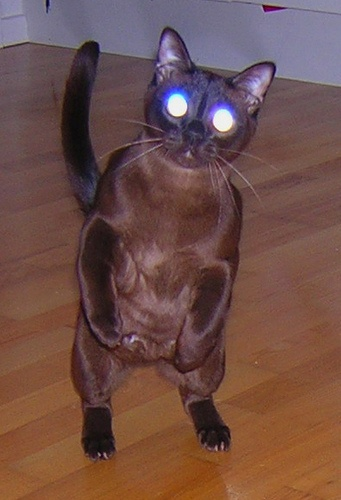

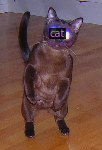

In [ ]:
# img = cv2.imread('/content/CatImages/00000001_000.jpg')
# cv2_imshow(img)

for d in random.sample(dataset2_dicts, 3):
  img_path = d["file_name"]
  print(d)
  img = cv2.imread(img_path)
  cv2_imshow(img)
  visualizer = Visualizer(img[:, :, ::-1], metadata=cat_metadata, scale=0.3)
  out = visualizer.draw_dataset_dict(d)
  cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
dataset2.head(2)

file_name  ... image_id
0  /content/CatImages/00000001_000.jpg  ...        1
1  /content/CatImages/00000001_005.jpg  ...        2

[2 rows x 5 columns]

这里之所以将trainset的index给重置了，是因为原始的trainset的index是从dataset里面来的，然后dataset被划分为了trainset和testset，index也是跟着一起走的，导致在trainset里面，他的index并不是连续的，在transform to coco的时候，由于循环是从0到数据集的长度的，循环的值是连续的，但是trainset里面的index并不是连续的，到处出错，就需要将trainset里面的index重置一遍。

In [ ]:
trainSet.sort_index()
trainSet.index = range(0,len(trainSet))
trainSet.head(5)

file_name  ... image_id
0  /content/CatImages/00000371_007.jpg  ...     1151
1  /content/CatImages/00000427_001.jpg  ...     1500
2  /content/CatImages/00000046_021.jpg  ...      337
3  /content/CatImages/00000080_005.jpg  ...      565
4  /content/CatImages/00000300_026.jpg  ...      687

[5 rows x 5 columns]

In [ ]:
testSet.sort_index()
testSet.index = range(0,len(testSet))
testSet.head(5)

file_name  ... image_id
0  /content/CatImages/00000078_028.jpg  ...      555
1  /content/CatImages/00000025_029.jpg  ...      203
2  /content/CatImages/00000411_016.jpg  ...     1411
3  /content/CatImages/00000351_025.jpg  ...     1020
4  /content/CatImages/00000369_001.jpg  ...     1139

[5 rows x 5 columns]

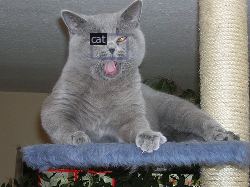

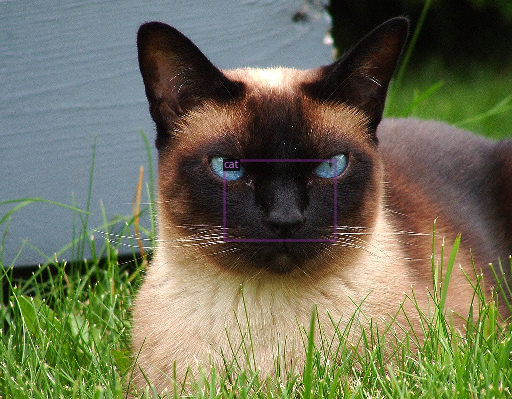

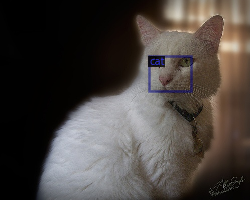

In [ ]:

train_dicts = transform_to_coco(trainSet)
for d in random.sample(train_dicts, 3):
  img_path = d["file_name"]
  # print(d)
  img = cv2.imread(img_path)
  # cv2_imshow(img)
  visualizer = Visualizer(img[:, :, ::-1], metadata=cat_metadata, scale=0.5)
  out = visualizer.draw_dataset_dict(d)
  cv2_imshow(out.get_image()[:, :, ::-1])

# test_dicts = transform_to_coco(testSet)
# for d in random.sample(test_dicts, 3):
#   img_path = d["file_name"]
#   # print(d)
#   img = cv2.imread(img_path)
#   # cv2_imshow(img)
#   visualizer = Visualizer(img[:, :, ::-1], metadata=cat_metadata, scale=0.5)
#   out = visualizer.draw_dataset_dict(d)
#   cv2_imshow(out.get_image()[:, :, ::-1])

## Training
* Initialize the model with pretrained weights: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-person-keypoint-detection-baselines-with-keypoint-r-cnn
* Set the training parameters:
```
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 3
cfg.TEST.KEYPOINT_OKS_SIGMAS = [.079, .107, .089]
```
* Train the model. (*Note: To debug your code, you can reduce the MAX_ITER to 300.*)  


In [ ]:
from detectron2.engine import DefaultTrainer
# Inference with a keypoint detection model
cfg = get_cfg()   # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("trainSet",)
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS=2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 3
cfg.TEST.KEYPOINT_OKS_SIGMAS = [.079, .107, .089]

# cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x.yaml"))
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model

cfg.MODEL.ROI_KEYPOINT_HEAD.MIN_KEYPOINTS_PER_IMAGE =1

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[01/05 18:20:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

TypeError: ignored

### Try out model

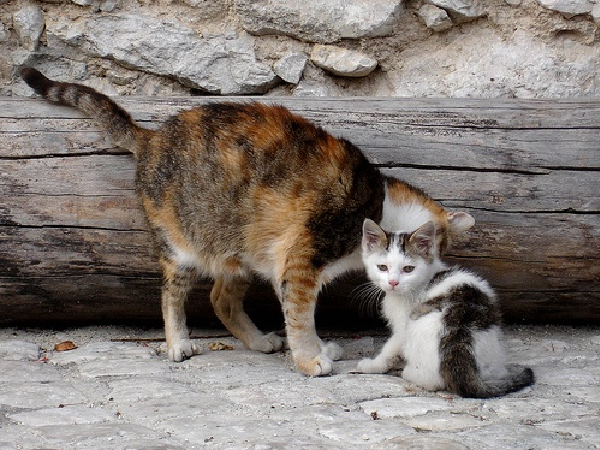

In [ ]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
# im = cv2.imread("./input.jpg")
im = cv2.imread("/content/CatImages/00000001_008.jpg")
cfg = get_cfg()   # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 3
cfg.TEST.KEYPOINT_OKS_SIGMAS = [.079, .107, .089]


predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

## Evaluation
* Evalute the model on the test set.
* Visualize some (e.g. 5) results.
* Run the model on the following videos:
  * https://www.youtube.com/watch?v=z3U0udLH974&ab_channel=TheCatsPyjaaaamas
  * https://www.youtube.com/watch?v=Y4z21xjv8KM&ab_channel=ONEMedia


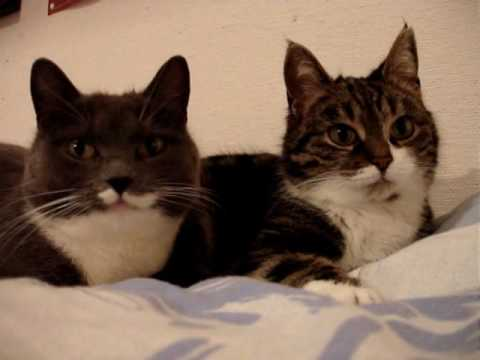

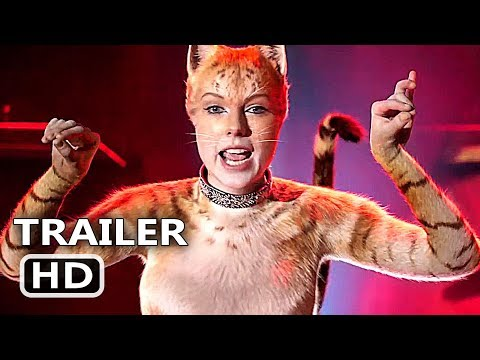

In [ ]:
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("z3U0udLH974", width=500)
display(video)
video = YouTubeVideo("Y4z21xjv8KM", width=500)
display(video)

Download the videos:

In [ ]:
!pip install youtube-dl
!pip uninstall -y opencv-python-headless opencv-contrib-python
!apt install python3-opencv  # the one pre-installed have some issues

!youtube-dl https://www.youtube.com/watch?v=z3U0udLH974&ab_channel=TheCatsPyjaaaamas 
!mv 'The two talking cats-z3U0udLH974.mkv' video1.mkv


# Install dependencies, download the video, and crop 5 seconds for processing

!ffmpeg -i video1.mkv -t 00:00:06 -c:v copy video1-clip.mkv

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-opencv is already the newest version (3.2.0+dfsg-4ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
[youtube] z3U0udLH974: Downloading webpage
[download] Destination: The two talking cats-z3U0udLH974.f244.webm
[download] 100% of 2.81MiB in 00:00
[download] Destination: The two talking cats-z3U0udLH974.f140.m4a
[download] 100% of 868.24KiB in 00:00
[ffmpeg] Merging formats into "The two talking cats-z3U0udLH974.mkv"
Deleting original file The two talking cats-z3U0udLH974.f244.webm (pass -k to keep)
Deleting original file The two talking cats-z3U0udLH974.f140.m4a (pass -k to keep)
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --en

In [ ]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes) with the "demo.py" tool we provided in the repo.
!git clone https://github.com/facebookresearch/detectron2
!python detectron2/demo/demo.py --config-file detectron2/configs/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml --video-input video1-clip.mkv --confidence-threshold 0.6 --output video1-output.mkv \
  --opts MODEL.WEIGHTS "/content/output/model_final.pth"

fatal: destination path 'detectron2' already exists and is not an empty directory.
Failed to load OpenCL runtime
** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

[01/05 21:15:44 detectron2]: Arguments: Namespace(confidence_threshold=0.6, config_file='detectron2/configs/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml', input=None, opts=['MODEL.WEIGHTS', '/content/output/model_final.pth'], output='video1-output.mkv', video_input='video1-clip.mkv', webcam=False)
[01/05 21:15:50 fvcore.common.checkpoint]: Loading checkpoint from /content/output/model_final.pth
WARNING [01/05 21:15:50 fvcore.common.checkpoint]: Skip loading parameter 'roi_heads.keypoint_head.score_lowres.weight' to the model due to incompatible shapes: (512, 9, 4,

In [ ]:
# Download the results
from google.colab import files
files.download('video1-output.mkv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

keypoint_rcnn_X_101_32x8d_FPN_3x

In [ ]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes) with the "demo.py" tool we provided in the repo.
!git clone https://github.com/facebookresearch/detectron2
!python detectron2/demo/demo.py --config-file detectron2/configs/COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x.yaml --video-input video-clip.mkv --confidence-threshold 0.6 --output video-output.mkv \
  --opts MODEL.WEIGHTS "/content/output/model_final.pth"

In [ ]:
!youtube-dl https://www.youtube.com/watch?v=Y4z21xjv8KM&ab_channel=ONEMedia
!mv 'CATS Trailer # 2 (2019) Taylor Swift, Idris Elba Movie HD-Y4z21xjv8KM.webm' video2.mkv
!ffmpeg -i video2.mkv -t 00:00:06 -c:v copy video2-clip.mkv
!git clone https://github.com/facebookresearch/detectron2
!python detectron2/demo/demo.py --config-file detectron2/configs/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml --video-input video2-clip.mkv --confidence-threshold 0.6 --output video2-output.mkv \
  --opts MODEL.WEIGHTS "/content/output/model_final.pth"

[youtube] Y4z21xjv8KM: Downloading webpage
[download] Destination: CATS Trailer # 2 (2019) Taylor Swift, Idris Elba Movie HD-Y4z21xjv8KM.f248.webm
[download] 100% of 22.16MiB in 00:00
[download] Destination: CATS Trailer # 2 (2019) Taylor Swift, Idris Elba Movie HD-Y4z21xjv8KM.f251.webm
[download] 100% of 1.49MiB in 00:00
[ffmpeg] Merging formats into "CATS Trailer # 2 (2019) Taylor Swift, Idris Elba Movie HD-Y4z21xjv8KM.webm"
Deleting original file CATS Trailer # 2 (2019) Taylor Swift, Idris Elba Movie HD-Y4z21xjv8KM.f248.webm (pass -k to keep)
Deleting original file CATS Trailer # 2 (2019) Taylor Swift, Idris Elba Movie HD-Y4z21xjv8KM.f251.webm (pass -k to keep)
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avres

In [ ]:
# Download the results
from google.colab import files
files.download('video2-output.mkv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

detectron2/configs/COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml

In [ ]:
!youtube-dl https://www.youtube.com/watch?v=Y4z21xjv8KM&ab_channel=ONEMedia
!mv 'CATS Trailer # 2 (2019) Taylor Swift, Idris Elba Movie HD-Y4z21xjv8KM.webm' video3.mkv
!ffmpeg -i video3.mkv -t 00:00:06 -c:v copy video3-clip.mkv
!git clone https://github.com/facebookresearch/detectron2
!python detectron2/demo/demo.py --config-file detectron2/configs/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml --video-input video3-clip.mkv --confidence-threshold 0.6 --output video3-output.mkv \
  --opts MODEL.WEIGHTS "/content/output/model_final.pth"


[youtube] Y4z21xjv8KM: Downloading webpage
[download] Destination: CATS Trailer # 2 (2019) Taylor Swift, Idris Elba Movie HD-Y4z21xjv8KM.f248.webm
[download] 100% of 22.16MiB in 00:00
[download] Destination: CATS Trailer # 2 (2019) Taylor Swift, Idris Elba Movie HD-Y4z21xjv8KM.f251.webm
[download] 100% of 1.49MiB in 00:00
[ffmpeg] Merging formats into "CATS Trailer # 2 (2019) Taylor Swift, Idris Elba Movie HD-Y4z21xjv8KM.webm"
Deleting original file CATS Trailer # 2 (2019) Taylor Swift, Idris Elba Movie HD-Y4z21xjv8KM.f248.webm (pass -k to keep)
Deleting original file CATS Trailer # 2 (2019) Taylor Swift, Idris Elba Movie HD-Y4z21xjv8KM.f251.webm (pass -k to keep)
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avres

In [ ]:
from google.colab import files
files.download('video3-output.mkv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Temporal extension (optional)
For more info see the description.